In [1]:
%pylab notebook
from serial import Serial
from PIL import Image
from threading import Thread
from io import BytesIO

def to888(arr565):
    H = arr565.shape[0]
    W = arr565.shape[1]
    img888 = zeros((H, W, 3), dtype=uint8)
    img888[:, :, 0] = (arr565 >> 11) << 3
    img888[:, :, 1] = ((arr565 >> 5) & 0x3F) << 2
    img888[:, :, 2] = (arr565 & 0x1F) << 3
    return img888

Populating the interactive namespace from numpy and matplotlib


In [ ]:
s = Serial(port='/dev/ttyUSB0', baudrate=1000000)

# Find a way to read and display RGB565 data

In [ ]:
W = 320
H = 240
headerDat = s.read_until(b'imagedata\n')
print(headerDat)
imgDat = s.read(W * H * 2)
img565 = frombuffer(imgDat, dtype=uint16).byteswap().reshape(H, W)
img = Image.fromarray(to888(img565), 'RGB')
img

# decode jpeg

In [ ]:
headerDat = s.read_until(b'imagedata\n')
print(headerDat[:100])
imgDat = s.read_until(b'finito!\n')
f_imgDat = BytesIO(imgDat)
img = Image.open(f_imgDat)
img

In [ ]:
imgDat[-16:]

# Auto-refresh a plot (serial)

In [ ]:
W = 320
H = 240
FMT = 'jpeg'
fig, axs = subplots()
l = axs.imshow(zeros((H, W)))
s = Serial(port='/dev/ttyUSB0', baudrate=1000000)
def read_from_port():
    while s.isOpen():
        headerDat = s.read_until(b'imagedata\n')
        print(headerDat[:100])
        if FMT == 'rgb565':
            imgDat = s.read(W * H * 2)
            img565 = frombuffer(imgDat, dtype=uint16).byteswap().reshape(H, W)
            # Update plot
            l.set_data(to888(img565))
        elif FMT == 'jpeg':
            imgDat = s.read_until(b'\xFF\xD9finito!\n')
            f_imgDat = BytesIO(imgDat)
            try:
                img = Image.open(f_imgDat)
                l.set_data(img)
            except Exception as e:
                print(e)
        fig.canvas.draw_idle()
    print("DONE!")
t = Thread(target=read_from_port)
t.start()

In [ ]:
s.close()

# Receive over UDP

In [3]:
import socket
s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.bind(("", 1331))

In [ ]:
seq = 0
tmp = b''
while True:
    data = s.recv(32000)
    if data[0] == 0:
        im_dat = tmp
        print(len(im_dat))
        tmp = data[1:]
        seq = 1
        print('0', end=' ')
    elif seq > 0:
        if data[0] == seq:
            tmp += data[1:]
            print(seq, end=' ')
            seq += 1
        else:
            seq = 0
            print("seq error")

In [ ]:
img565 = frombuffer(im_dat, dtype=uint16).byteswap().reshape(-1, W)
img = to888(img565)
close()
imshow(img)

In [ ]:
print(len(im_dat))
f_imgDat = BytesIO(im_dat)
img = Image.open(f_imgDat)
img

<IPython.core.display.Javascript object>


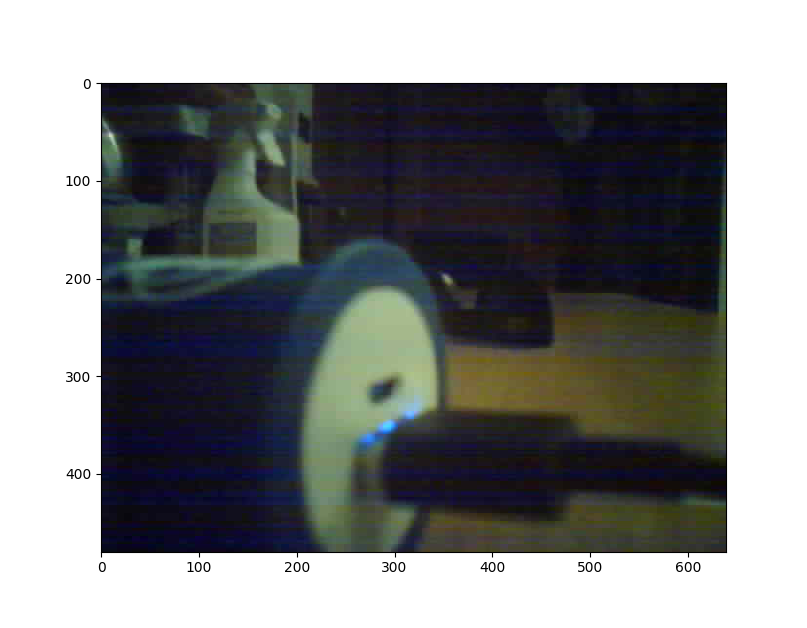

0 1 2 3 4 5 p 6717


In [4]:
# W, H = 320, 240
W, H = 640, 480
FMT = 'jpeg'
is_run = True
im_dat = None

close()
fig, axs = subplots()
l = axs.imshow(zeros((H, W)))

def procData(tmp):
    if tmp is None or len(tmp) <= 0:
        return
    print('p', len(tmp))
    if FMT == 'rgb565':
        img565 = frombuffer(tmp, dtype=uint16).byteswap().reshape(-1, W)
        # Update plot
        img = to888(img565)
    elif FMT == 'jpeg':
        f_imgDat = BytesIO(tmp)
        img = Image.open(f_imgDat)
    l.set_data(img)
    fig.canvas.draw_idle()
    
def read_from_port():
    tmp = b''
    seq = 0
    while is_run:
        data = s.recv(32000)
        if data[0] == 0:
            try:
                procData(tmp)
            except Exception as e:
                print(e)
            tmp = data[1:]
            print('0', end=' ')
            seq = 1
        elif seq > 0:
            if data[0] == seq:
                tmp += data[1:]
                print(seq, end=' ')
                seq += 1
            else:
                seq = 0
                print("seq error")
    print("DONE!")
    
t = Thread(target=read_from_port)
t.start()

In [10]:
print(t.is_alive())
is_run = False

True
